# Gamma Regression

### Imports

In [1]:
import numpy as np
import numpy.random as random
import scipy.optimize

import matplotlib.pyplot as plt

from scipy.special import factorial
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.special as special

import pandas as pd

import sys

%matplotlib inline

In [2]:
seed=567
np.random.seed(seed)

## Gamma Regression

When $Y\in\mathbb{R}^+$, ie $y>0$ is   positive real numbers it is  natural to assume that $Y|_X$ follows a $\Gamma$   distribution. For simplicity we will assume $\alpha$ is a fixed **known** parameter. 

$$
    p(y|x) = \frac{\beta^\alpha}{\Gamma(\alpha)}s^{\alpha-1}e^{-\beta s} = \frac{s^{\alpha-1}}{\Gamma(\alpha)}e^{ -y\beta +  \alpha\log \beta }
$$  
were $\alpha>0$ and $\beta>0$

And a non-canonical log link

$$
    \eta(x) = -e^{-b_0 - W_0 x}
$$



### Generate random sample data

In [3]:
alpha=5.0

The true parameters used to generate the data are
$$
    \theta_0=(b_0,w_0)=(0,1)
$$

In [4]:
b0=0
W0=1


theta0=np.array([b0,W0])
theta0.shape

(2,)

We generate $N=30$ samples, with $X\sim \mathcal{U}(0,4)$.

In [5]:
N=30
X=np.random.uniform(0,4,(N,1))
X.shape

(30, 1)

In [6]:
X1=np.c_[np.ones(len(X)),X]

b=np.exp(np.dot(X1,theta0))

Y=stats.gamma.rvs(a=alpha,scale=b)
Y.shape

(30,)

Text(0, 0.5, 'Y')

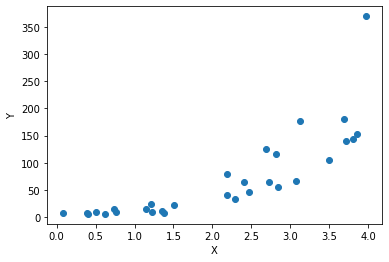

In [7]:
plt.scatter(X,Y)
plt.xlabel('X')
plt.ylabel('Y')


## Fit linear model


To demonstrate what goes wrong with a linear least squares model, we fit the data to a linear regression.


In [8]:
model=LinearRegression()
model.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
x_test=np.linspace(0,4,201).reshape(-1,1)
Y_pred_linear=model.predict(x_test)

Text(0, 0.5, 'Y , Y_pred')

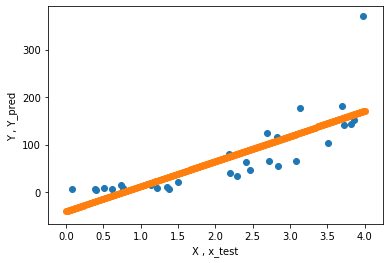

In [10]:
plt.scatter(X,Y)
plt.scatter(x_test,Y_pred_linear)
plt.xlabel('X , x_test')
plt.ylabel('Y , Y_pred')

## Gamma Regression

We just use the standard `scipy.optimize.minimize` routine to fit a Gamma Regression model to the data.

### Link Function

In [11]:
def y_hat(X,alpha,theta):
    b=np.exp(np.dot(X,theta))
    return alpha*b

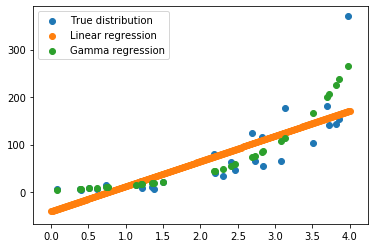

In [12]:
Y_hat=y_hat(X1,alpha,theta0)

plt.scatter(X,Y,label='True distribution')
plt.scatter(x_test,Y_pred_linear,label='Linear regression')
plt.scatter(X,Y_hat,label='Gamma regression')
plt.legend()



### Loss and Loss Gradient


Max likelihood loss for the Gamma Regression problem with log link

$$
E^{\textrm{log}}_{\textrm{Gam}}(\theta;X_1,Y,\alpha)
$$

where $X_1$ is a $2\times N$ matrix and $Y$ is a $N$ vector of input data

In [13]:
def GammaError(theta,X1,Y,alpha):
    Gamma=(alpha*np.dot(X1,theta)+Y*np.exp(-np.dot(X1,theta))).mean()
    return Gamma

Gradient max likelihood loss for the Gamma Regression problem with log link

$$
\frac{\partial}{\partial \theta_d} E^{\textrm{log}}_{\textrm{Gam}}(\theta;X_1,Y,\alpha)
$$


In [14]:
def GammaErrorGradient(theta,X1,Y,alpha):
    gradient_b=(alpha-Y*np.exp(-np.dot(X1,theta))).mean()
    gradient_omega=np.dot(X1[:,1],alpha-Y*np.exp(-np.dot(X1,theta)))/len(X1)
    return np.array([gradient_b,gradient_omega])

Function `scipy.minimize.check_gra` to verify that the gradient function is 
implemented correctly at the point 
$$
    \theta_{\textrm{test}} = (-1,1.5)
$$


In [15]:
theta_test=np.array([-1,1.5])

In [16]:
scipy.optimize.check_grad(GammaError,GammaErrorGradient,theta_test,X1,Y,alpha)

2.745349270055516e-07

### Optimization

In [17]:
class GammaRegression:
    def __init__(self,alpha):
        self.alpha=alpha
    def fit(self,X,Y):
        X1=np.c_[np.ones(len(X)),X]
        theta0=np.random.normal(0,1/np.sqrt(2),2)
        fit=optimize.minimize(GammaError,theta0,jac=GammaErrorGradient,args=(X1,Y,self.alpha),method="bfgs")
        self.theta=fit.x
    def predict(self,X):
        X1=np.c_[np.ones(len(X)),X]
        l=y_hat(X1,self.alpha,self.theta)
        return l
    

In [18]:
gamma_model=GammaRegression(alpha)
gamma_model.fit(X,Y)



Y_pred_gamma=gamma_model.predict(X)

print(f'The estimated theta is {gamma_model.theta}')


The estimated theta is [0.00271237 0.98051357]


The Gamma model fits the data much better

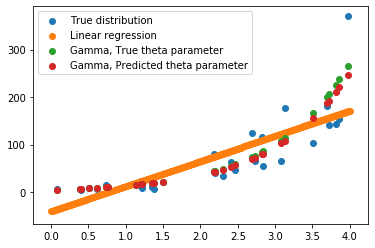

In [19]:
plt.scatter(X,Y,label='True distribution')
plt.scatter(x_test,Y_pred_linear,label='Linear regression')
plt.scatter(X,Y_hat,label='Gamma, True theta parameter')
plt.scatter(X,Y_pred_gamma,label='Gamma, Predicted theta parameter')

plt.legend()

## Dependence on $\alpha$

Keeping $X$ and $Y$ Fixed


Dependency of the fitted parameters $\hat{b}$ and $\hat{w}$  for fitting

Text(0.5, 1.0, 'w=f(alpha)')

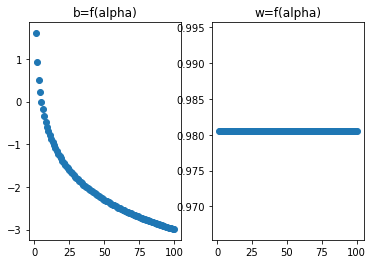

In [20]:
alpha=np.linspace(1,100,100)
b=[]
w=[]
for i in alpha:
    gamma_model=GammaRegression(i)
    gamma_model.fit(X,Y)
    theta=gamma_model.theta
    b.append(theta[0])
    w.append(theta[1])

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.scatter(alpha,b)
ax1.set_title('b=f(alpha)')
ax2.scatter(alpha,w)
ax2.set_title('w=f(alpha)')


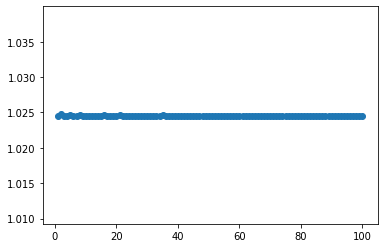

In [21]:
alpha=np.linspace(1,100,100)
dY=[]

for i in alpha:
    gamma_model=GammaRegression(i)
    gamma_model.fit(X,Y)
    Y_pred=gamma_model.predict(X)
    dY.append(np.average(Y_pred-Y)**2)

plt.scatter(alpha,dY)


## there is nearly no dependence between the predicted levels of Y and the parameter alpha used for fitting 
    